In [162]:
#scaling constants
B_b   = 1e1
b_B   = 1/B_b
G_1   = 1e9
one_G = 1/G_1
G_K   = 1e6
K_G   = 1/G_K
G_M   = 1e3
M_G   = 1/G_M
K_1   = 1e3
one_K = 1/K_1
M_1   = 1e6
one_M = 1/M_1
m_1   = 1e-3
one_m = 1/m_1
m_u   = 1e3 
u_m   = 1/m_u
u_1   = 1e-6
one_u = 1/u_1
n_1   = 1e-9
one_n = 1/n_1
n_m   = 1e-6
m_n   = 1/n_m

sz1K  = 1024
sz1M  = sz1K*sz1K
sz1G  = sz1M*sz1K


In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import re
from datetime import datetime

sns.set(style="darkgrid")

# Compute statistical moments: mean, std, skewness, kurtosis
def compute_moments(series):
    values = series.dropna()
    return {
        'count': len(values),
        'mean': values.mean(),
        'std': values.std(),
        'skew': skew(values),
        'kurtosis': kurtosis(values)
    }

# Load the log file into a list of lines
def load_log_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    return [line.strip() for line in lines if line.strip()]


In [164]:
# Replace this with the actual path to your log file
log_path = "emu_log.txt"

# Load and inspect
lines = load_log_file(log_path)
print(f"Loaded {len(lines)} lines from the log.")


Loaded 2909 lines from the log.


In [165]:
# Hack to determine minimum time stamp for zero based clock
timestamps = []
waiting_lines = [line for line in lines if "emulate_stream" in line and "emulate_sender-zmq" not in line]
for line in waiting_lines[0:5]:
    match = re.search(r"\(1\)", line)
    if match:
        # extract timestamp at the beginning of the line
        ts_match = re.match(r"([\d.]+)", line)
        print(f"ts_match = {ts_match}")
        timestamps.append(int(ts_match.group(1)) if ts_match else None)
    else:
        print("No match")
min_uS = min(timestamps)
print(min_uS)# print(min_uS)

ts_match = <re.Match object; span=(0, 16), match='1753391863771305'>
No match
No match
No match
No match
1753391863771305


In [166]:
waiting_lines[0:5]
timestamps

[1753391863771305]

📊 Sender Estimated Frame Rate Statistics:
count: 100.000
mean: 33.513
std: 0.305
skew: 1.496
kurtosis: 9.462


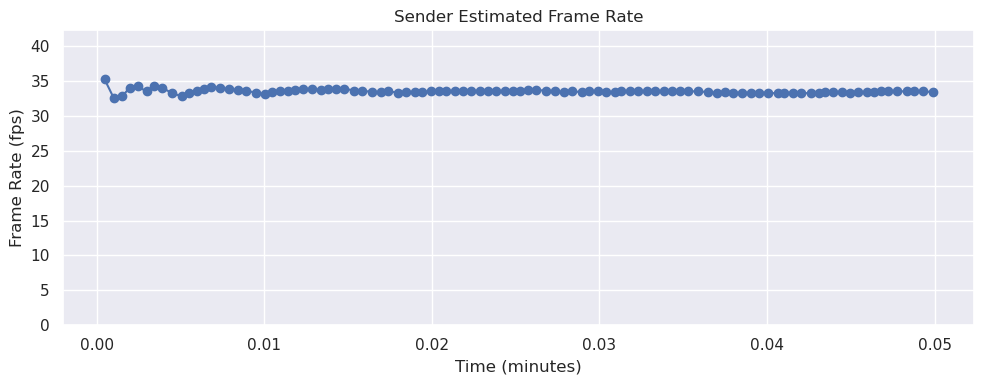

In [167]:
# Extract lines with frame rate information
frame_rate_lines = [line for line in lines if "[emulate_stream:] Estimated frame rate (Hz): " in line]

# Parse frame rate values from lines
frame_rates = []
timestamps = []
for line in frame_rate_lines:
    match = re.search(r"\[emulate_stream:\] Estimated frame rate \(Hz\): ([\d.]+)", line)
    if match:
        value = float(match.group(1))
        frame_rates.append(value)
        # Optional: extract timestamp if available at the beginning of the line
        ts_match = re.match(r"([\d.]+)", line)
        timestamps.append(ts_match.group(1) if ts_match else None)
    else:
        print("No match")

# Create a DataFrame
frame_rate_df = pd.DataFrame({
#    'timestamp': pd.to_datetime(timestamps, errors='coerce'),
    'timestamp': timestamps,
    'frame_rate': frame_rates
})

# Display statistics
frame_rate_stats = compute_moments(frame_rate_df['frame_rate'])

# Convert microseconds to zero based minutes
frame_rate_df['minutes'] = ((frame_rate_df['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes

print("📊 Sender Estimated Frame Rate Statistics:")
for k, v in frame_rate_stats.items():
    print(f"{k}: {v:.3f}")
# Plot
plt.figure(figsize=(10, 4))
plt.plot(frame_rate_df['minutes'], frame_rate_df['frame_rate'], marker='o', linestyle='-')

plt.title('Sender Estimated Frame Rate')
plt.xlabel('Time (minutes)')
plt.ylabel('Frame Rate (fps)')
plt.ylim(0, max(frame_rate_df['frame_rate']) * 1.2)  # Give headroom
plt.grid(True)

plt.tight_layout()
plt.show()

In [168]:
# frame_rate_lines[0:3]
# lines[:10]
#frame_rates

In [169]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Set Seaborn style
# sns.set(style="whitegrid", context="talk")

# # Create the Seaborn line plot
# plt.figure(figsize=(10, 4))
# sns.lineplot(
#     data=frame_rate_df,
#     x='minutes',
#     y='frame_rate',
#     marker='o',
#     linewidth=2,
#     color='royalblue'
# )

# # Customize labels and title
# plt.title('Sender Estimated Frame Rate', fontsize=16)
# plt.xlabel('Time (minutes)', fontsize=14)
# plt.ylabel('Frame Rate (fps)', fontsize=14)
# plt.ylim(0, frame_rate_df['frame_rate'].max() * 1.2)
# plt.tight_layout()
# plt.show()


In [170]:
# frame_rate_df['timestamp'].astype(float).head(5)

📊 Sender Bit Rate Statistics (bps):
count: 100.000
mean: 19.871
std: 0.028
skew: -5.805
kurtosis: 38.845


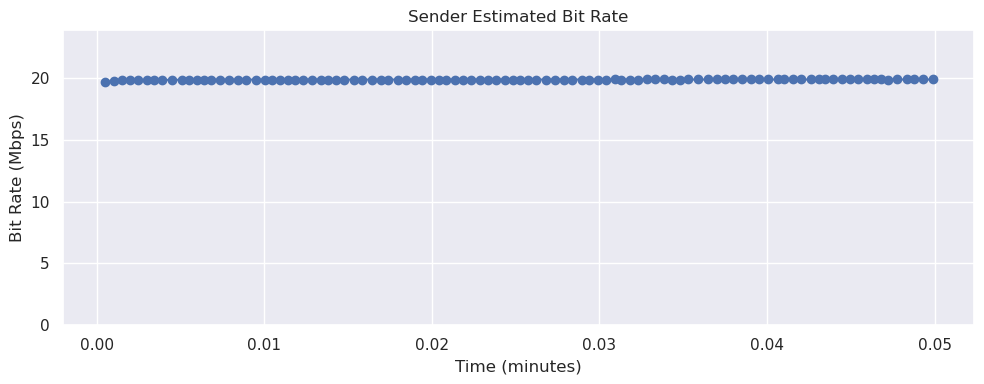

In [171]:
# Extract lines with bit rate information
bit_rate_lines = [line for line in lines if "[emulate_stream:] Estimated bit rate (bps):" in line]

# Parse bit rate values and timestamps
bit_rates = []
timestamps = []
for line in bit_rate_lines:
    match = re.search(r"\[emulate_stream:\] Estimated bit rate \(bps\): ([\d.]+)", line)
    if match:
        value = float(match.group(1))
        bit_rates.append(value*one_M)
        ts_match = re.match(r"([\d.]+)", line)
        timestamps.append(ts_match.group(1) if ts_match else None)
    else:
        print("No match in bit rate line:", line)

# Create a DataFrame
bit_rate_df = pd.DataFrame({
    'timestamp': timestamps,
    'bit_rate': bit_rates
})

# Convert microseconds to zero based minutes
bit_rate_df['minutes'] = ((bit_rate_df['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes

# Compute statistics
bit_rate_stats = compute_moments(bit_rate_df['bit_rate'])

# Display statistics
print("📊 Sender Bit Rate Statistics (bps):")

for k, v in bit_rate_stats.items():
    print(f"{k}: {v:.3f}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(bit_rate_df['minutes'], bit_rate_df['bit_rate'], marker='o', linestyle='-')
plt.title('Sender Estimated Bit Rate')
plt.xlabel('Time (minutes)')
plt.ylabel('Bit Rate (Mbps)')
plt.ylim(0, max(bit_rate_df['bit_rate']) * 1.2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [172]:
bit_rate_df.head(5)

,timestamp,bit_rate,minutes
0,1753391863799725,19.651604,0.000474
1,1753391863832891,19.759670,0.001026
2,1753391863862735,19.801260,0.001524
3,1753391863888815,19.817712,0.001958
4,1753391863917625,19.830844,0.002439


📊 Sender Frame Size Statistics (kB):
count: 100.000
mean: 59.476
std: 6.479
skew: 0.053
kurtosis: -0.287


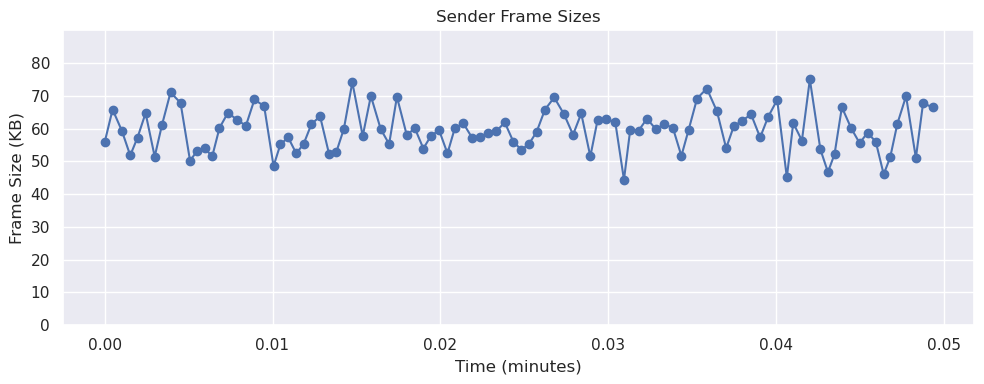

In [173]:
# Extract lines with bit rate information
sent_frame_lines = [line for line in lines if "[emulate_stream:]" in line and "Sending frame" in line]

# Parse bit rate values and timestamps
frame_sizes = []
timestamps = []
for line in sent_frame_lines:
    match = re.search(r"\[emulate_stream:\] Sending frame size = ([\d.]+)", line)
    if match:
        value = float(match.group(1))
        frame_sizes.append(value*one_K)
        ts_match = re.match(r"([\d.]+)", line)
        timestamps.append(ts_match.group(1) if ts_match else None)
    else:
        print("No match in frame size line:", line)

# Create a DataFrame
frame_size_df = pd.DataFrame({
    'timestamp': timestamps,
    'frame_size': frame_sizes
})

# Convert microseconds to hours
frame_size_df['hours'] = (frame_size_df['timestamp'].astype(float)-min_uS) / 3_600_000_000
# Convert microseconds to zero based minutes
frame_size_df['minutes'] = frame_size_df['hours']*60  #minutes

# Compute statistics
frame_size_stats = compute_moments(frame_size_df['frame_size'])

# Display statistics
print("📊 Sender Frame Size Statistics (kB):")

for k, v in frame_size_stats.items():
    print(f"{k}: {v:.3f}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(frame_size_df['minutes'], frame_size_df['frame_size'], marker='o', linestyle='-')
plt.title('Sender Frame Sizes')
plt.xlabel('Time (minutes)')
plt.ylabel('Frame Size (KB)')
plt.ylim(0, max(frame_size_df['frame_size']) * 1.2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [174]:
min_uS

1753391863771305

In [175]:
len(sent_frame_lines)

100

In [176]:
timestamps[0:5]

['1753391863771305',
 '1753391863799721',
 '1753391863832887',
 '1753391863862731',
 '1753391863888811']

In [177]:
frame_size_df.head(5)

,timestamp,frame_size,hours,minutes
0,1753391863771305,55.822,0.000000,0.000000
1,1753391863799721,65.822,0.000008,0.000474
2,1753391863832887,59.331,0.000017,0.001026
3,1753391863862731,51.815,0.000025,0.001524
4,1753391863888811,57.267,0.000033,0.001958


In [178]:
# sent_frame_lines = [line for line in lines if "[emulate_stream:]" in line and "Sending frame" in line]
# sent_frame_lines[:5]

In [179]:
# frame_size_df.head(5)

In [180]:
# recd_lines = [line for line in lines if "cpu_emu" in line and "6004" in line and "done" in line]
# recd_lines[:5]

In [181]:
#determine emulation port range
#port_lines = [line for line in lines if "Connecting to receiver tcp" in line]
cmpnt_ids = []
port_lines = [line for line in lines if "Subscribing to" in line]
#port_lines
for line in port_lines:
    match = re.search(r"cpu_emu ([\d.]+)", line)
    if match:
        value = float(match.group(1))
        cmpnt_ids.append(int(value))
    else:
        print("No match in port line:", line)
cmpnt_ids


[6000]

In [182]:
# port_lines[:5]


🔧 Component 0:
Component 0 Statistics (Hz):
count: 90.000
mean: 31.158
std: 0.168
skew: 1.079
kurtosis: 1.624


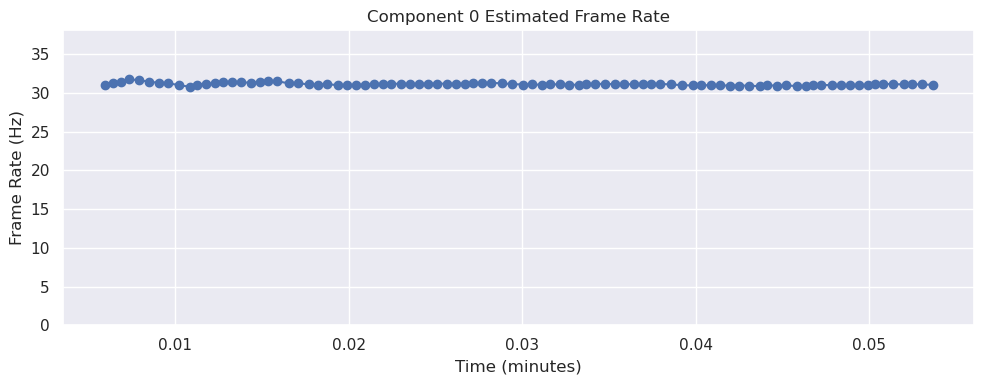

In [183]:
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "Measured frame rate" in line]
    # Parse frame rate values and timestamps
    frame_rates = []
    timestamps = []
    for line in comp_lines:
        match = re.search(r"Measured frame rate ([\d.]+)", line)
        if match:
            value = float(match.group(1))
            frame_rates.append(value)
            ts_match = re.match(r"([\d.]+)", line)
            timestamps.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in frame size line:", line)
    
    # Create a DataFrame
    frame_rate_df0 = pd.DataFrame({
        'timestamp': timestamps,
        'frame_rate': frame_rates
    })
    # Convert microseconds to zero based minutes
    frame_rate_df0['minutes'] = ((frame_rate_df0['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    #eliminate warm-up
    frame_rate_df = frame_rate_df0[int(len(frame_rate_df0) * 0.1):]

    # Compute statistics
    frame_rate_stats = compute_moments(frame_rate_df['frame_rate'])
    
    # Display statistics
    print(f"Component {index} Statistics (Hz):")
    
    for k, v in frame_rate_stats.items():
        print(f"{k}: {v:.3f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(frame_rate_df['minutes'], frame_rate_df['frame_rate'], marker='o', linestyle='-')
    plt.title(f"Component {index} Estimated Frame Rate")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Frame Rate (Hz)')
    plt.ylim(0, max(frame_rate_df['frame_rate']) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [184]:

# comp_lines = [line for line in lines if f"cpu_emu {6003}" in line and "Measured frame rate" in line]
# print(cmpnt_ids)
# print(list(enumerate(cmpnt_ids)))
# print(comp_lines[:5])

In [185]:
# print(comp_lines[:5])


🔧 Component 0:
Component 0, port 6000 Statistics (Hz):
count: 90.000
mean: 18.484
std: 0.004
skew: 1.390
kurtosis: 1.985


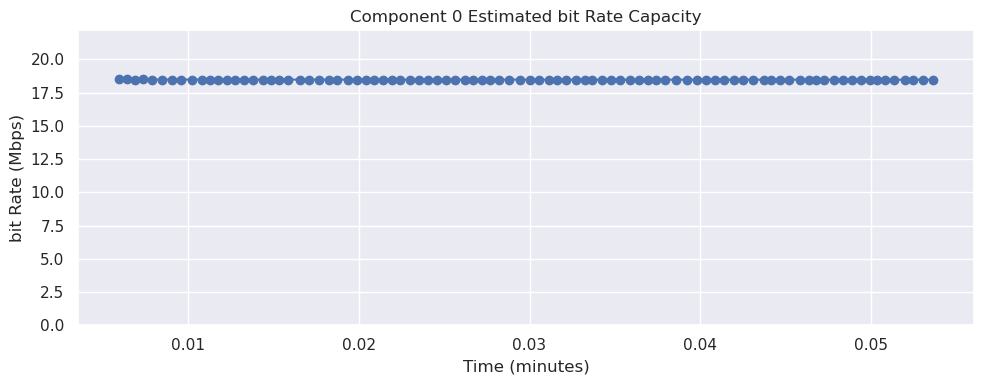

In [186]:
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "Measured bit rate" in line]
    # Parse bit rate values and timestamps
    bit_rates = []
    timestamps = []
    for line in comp_lines:
        match = re.search(r"Measured bit rate ([\d.]+)", line)
        if match:
            value = float(match.group(1))*one_M
            bit_rates.append(value)
            ts_match = re.match(r"([\d.]+)", line)
            timestamps.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in bit line:", line)
    
    # Create a DataFrame
    bit_rate_df0 = pd.DataFrame({
        'timestamp': timestamps,
        'bit_rate': bit_rates
    })

    # Convert microseconds to zero based minutes
    bit_rate_df0['minutes'] = ((bit_rate_df0['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
       
    #eliminate warm-up
    bit_rate_df = bit_rate_df0[int(len(bit_rate_df0) * 0.1):]

    # Compute statistics
    bit_rate_stats = compute_moments(bit_rate_df['bit_rate'])
    
    # Display statistics
    print(f"Component {index}, port {cmpnt_id} Statistics (Hz):")
    
    for k, v in bit_rate_stats.items():
        print(f"{k}: {v:.3f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(bit_rate_df['minutes'], bit_rate_df['bit_rate'], marker='o', linestyle='-')
    plt.title(f"Component {index} Estimated bit Rate Capacity")
    plt.xlabel('Time (minutes)')
    plt.ylabel('bit Rate (Mbps)')
    plt.ylim(0, max(bit_rate_df['bit_rate']) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



🔧 Component 0:
Component 0, port 6000 Statistics (Hz):
count: 99.000
mean: 18.857
std: 2.865
skew: 0.673
kurtosis: 0.488


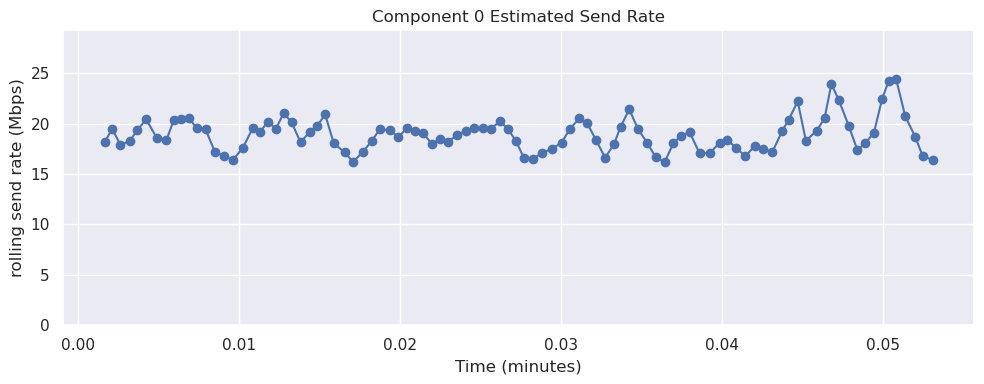

In [187]:
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "Sending frame size" in line]
    if not comp_lines:
        break
    # Parse bit rate values and timestamps
    send_sizes_b = []
    send_times_S = []
    for line in comp_lines:
        match = re.search(r"size = ([\d.]+)", line)
        if match:
            value = B_b*float(match.group(1))*1
            send_sizes_b.append(value)
            ts_match = re.match(r"([\d.]+)", line)
            send_times_S.append(int(ts_match.group(1) if ts_match else None))
        else:
            print("No match in Sending Frame line:", line)
    
    # Create a DataFrame
    sends_df = pd.DataFrame({
        'send_size_b': send_sizes_b,
        'send_time_S': send_times_S
    })

    # Convert microseconds to zero based minutes
    sends_df['minutes'] = ((sends_df['send_time_S'].astype(float)-min_uS) * u_1)/60  #minutes
       
    #eliminate warm-up
    #sends_df = sends_df0[int(len(send_time_df0) * 0.1):]

    # Compute instantaneous bit rate
    sends_df['dt_S'] = sends_df['send_time_S'].diff()
    #sends_df['sz_B'] = sends_df['send_size_b'].diff()
    sends_df['bitrate_bps'] = (sends_df['send_size_b'] * 1) / sends_df['dt_S']
    #send_time_df['bitrate_bps'].fillna(0, inplace=True)
    
    # Rolling bit rate (window size of 3, centered)
    sends_df['bitrate_rolling'] = sends_df['bitrate_bps'].rolling(window=3, center=True).mean()
    
    # Show result
    #print(df[['time', 'bytes', 'bitrate_bps', 'bitrate_rolling']])

    # Compute statistics
    sends_df_stats = compute_moments(sends_df['bitrate_bps'])
    
    #print(comp_lines[0:3])
    #print(sends_df.head(3))
    
    # Display statistics
    print(f"Component {index}, port {cmpnt_id} Statistics (Hz):")
    
    for k, v in sends_df_stats.items():
        print(f"{k}: {v:.3f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(sends_df['minutes'], sends_df['bitrate_rolling']*1, marker='o', linestyle='-')
    plt.title(f"Component {index} Estimated Send Rate")
    plt.xlabel('Time (minutes)')
    plt.ylabel('rolling send rate (Mbps)')
    plt.ylim(0, max(sends_df['bitrate_rolling'].dropna()*1) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [188]:
# sends_df.head(5)


🔧 Component 0:
Component 0, port 6000 Statistics (Hz):
count: 100.000
mean: 31.934
std: 3.476
skew: 0.056
kurtosis: -0.294


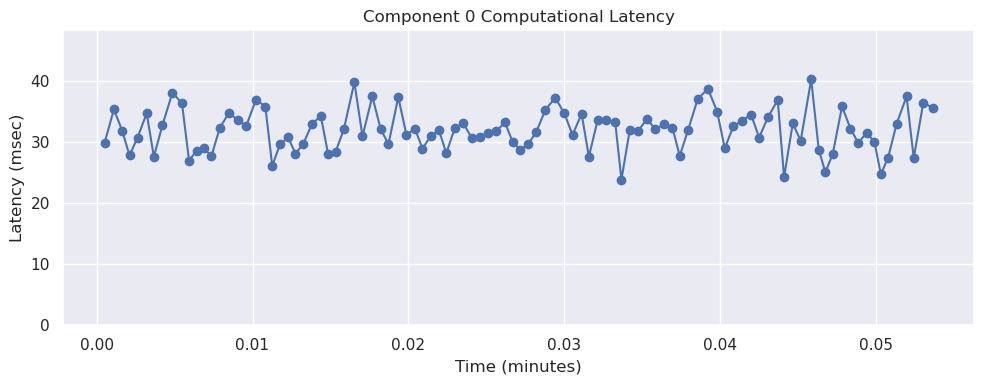

In [189]:
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "Measured latencies" in line]
    # Parse bit rate values and timestamps
    y = []
    x = []
    for line in comp_lines:
        match = re.search(r"last_cmp_lat_uS = ([\d.]+)", line)
        if match:
            value = int(match.group(1))
            y.append(value*u_m)
            ts_match = re.match(r"([\d.]+)", line)
            x.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in latency line:", line)
    
    # Create a DataFrame
    latency = pd.DataFrame({
        'timestamp': x,
        'latency': y
    })

    # Convert microseconds to zero based minutes
    latency['minutes'] = ((latency['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    # Compute statistics
    latency_stats = compute_moments(latency['latency'])
    
    # Display statistics
    print(f"Component {index}, port {cmpnt_id} Statistics (Hz):")
    
    for k, v in latency_stats.items():
        print(f"{k}: {v:.3f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(latency['minutes'], latency['latency'], marker='o', linestyle='-')
    plt.title(f"Component {index} Computational Latency")
    plt.xlabel('Time (minutes)')
    plt.ylabel('Latency (msec)')
    plt.ylim(0, max(latency['latency']) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



🔧 Component 0:
Component 6000, port 6000 Statistics (usec):
count: 99.000
mean: 111.363
std: 65.094
skew: 0.003
kurtosis: -1.206
Number of drops is: 0
drop % is: 0.0


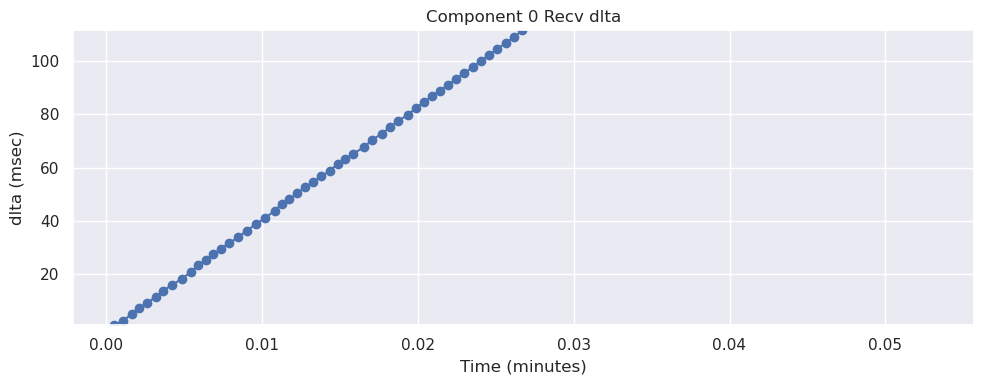

In [190]:
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "comparing" in line]
    # Parse bit rate values and timestamps
    y  = []
    x  = []
    for line in comp_lines:
        match = re.search(r"last_rdy_uS ([\d.]+)", line)
        if match:
            value = float(match.group(1))
            ts_match = re.match(r"([\d.]+)", line)
            x.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in last_rdy_uS line:", line)
        match = re.search(r"parsed.timestamp_uS ([\d.]+)", line)
        if match:
            value1 = float(match.group(1))
            y.append((value1-value)*u_m) #u_m
        else:
            print("No match in parsed.timestamp_uS line:", line)
    
    # Create a DataFrame
    drops = pd.DataFrame({
        'timestamp': x,
        'dlta': y
    })
    #First record is useless for this report
    drops.drop(index=drops.index[0], inplace=True)
    
    # Convert microseconds to zero based minutes
    drops['minutes'] = ((drops['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    # Compute statistics
    drops_stats = compute_moments(drops['dlta'])
    
    # Display statistics
    print(f"Component {cmpnt_id}, port {cmpnt_id} Statistics (usec):")
    
    for k, v in drops_stats.items():
        print(f"{k}: {v:.3f}")
        
    neg_count = sum(1 for d in y if d < 0)
    print(f"Number of drops is: {neg_count}")
    print(f"drop % is: {100*neg_count/len(y):.1f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(drops['minutes'], drops['dlta'], marker='o', linestyle='-')
    plt.title(f"Component {index} Recv dlta")
    plt.xlabel('Time (minutes)')
    plt.ylabel('dlta (msec)')
    plt.ylim(min(drops['dlta']), (drops['dlta'].mean()))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [191]:
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "comparing" in line]
    # Parse bit rate values and timestamps
    y  = []
    x  = []
    for line in comp_lines:
        match = re.search(r"last_rdy_uS ([\d.]+)", line)
        if match:
            value = float(match.group(1))
            ts_match = re.match(r"([\d.]+)", line)
            x.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in last_rdy_uS line:", line)
        match = re.search(r"parsed.timestamp_uS ([\d.]+)", line)
        if match:
            value1 = float(match.group(1))
            y.append((value1-value)*u_m) #u_m
        else:
            print("No match in parsed.timestamp_uS line:", line)
    
    # Create a DataFrame
    drops = pd.DataFrame({
        'timestamp': x,
        'dlta': y
    })
    #First record is useless for this report
    drops.drop(index=drops.index[0], inplace=True)
    
    # Convert microseconds to zero based minutes
    drops['minutes'] = ((drops['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    # Compute statistics
    drops_stats = compute_moments(drops['dlta'])
    
    # Display statistics
    print(f"Component {cmpnt_id}, port {cmpnt_id} Statistics (usec):")
    
    for k, v in drops_stats.items():
        print(f"{k}: {v:.3f}")
        
    neg_count = sum(1 for d in y if d < 0)
    print(f"Number of drops is: {neg_count}")
    print(f"drop % is: {100*neg_count/len(y):.1f}")
    


🔧 Component 0:
Component 6000, port 6000 Statistics (usec):
count: 99.000
mean: 111.363
std: 65.094
skew: 0.003
kurtosis: -1.206
Number of drops is: 0
drop % is: 0.0


In [192]:
# drops.head(5)

In [193]:
#max(latency['latency'])
# comp_lines[0:5]

/scratch/slurm/51154007/.cache/tmp/ipykernel_659231/3158271011.py:31: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, max(drops['fraction']) * 1.2)
/scratch/slurm/51154007/.cache/tmp/ipykernel_659231/3158271011.py:32: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(int(min(drops['component'])), int(max(drops['component'])))


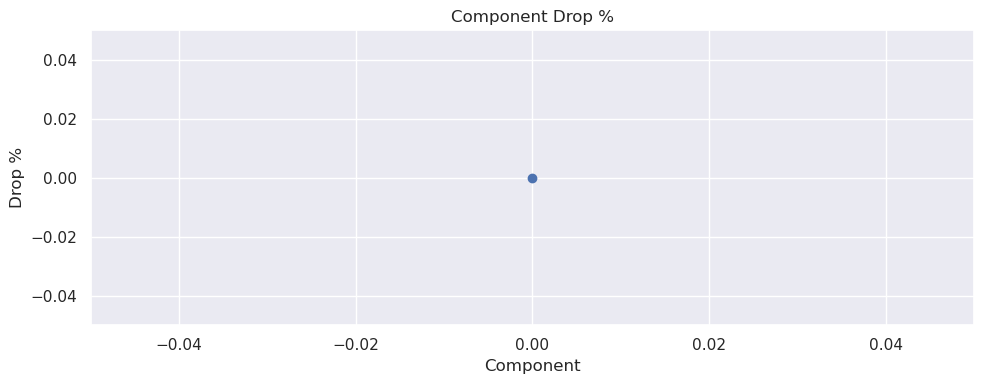

In [194]:
y = []
x = []
for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    # Filter lines for this component
    drop_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "drop" in line]
    recd_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "recd" in line]
    #print("Frames Recvd:",len(recd_lines))
    #print("Frames Dropped:",len(drop_lines))
    d = len(drop_lines)
    r = len(recd_lines)
    #print("Drop frames fraction: ", d/r)
    x.append(int(index))
    y.append(100*d/r)
#    print(f"drop % is: {100*neg_count/len(y):.1f}")
    
# Create a DataFrame
drops0 = pd.DataFrame({
    'component': x,
    'fraction': y
})

drops = drops0.sort_values(by='component', ascending=False)
    
# Plot
plt.figure(figsize=(10, 4))
plt.plot(drops['component'], drops['fraction'], marker='o', linestyle='-')
plt.title(f"Component Drop %")
plt.xlabel('Component')
plt.ylabel('Drop %')
plt.ylim(0, max(drops['fraction']) * 1.2)
plt.xlim(int(min(drops['component'])), int(max(drops['component'])))
plt.grid(True)
plt.tight_layout()
plt.show()

In [195]:
# drops0

In [196]:
def find_missing_integers(sequence):
    if not sequence:
        return [], 0

    sorted_seq = sorted(set(sequence))
    full_range = set(range(sorted_seq[0], sorted_seq[-1] + 1))
    missing = sorted(full_range - set(sorted_seq))

    return missing, len(missing)

for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "dropped" in line]
    # Parse bit rate values and timestamps
    x  = []
    for line in comp_lines:
        match = re.search(r"dropped \(([\d.]+)\)", line)
        if match:
            value = int(match.group(1))
            #print(value)
            x.append(value)
        else:
            print("No match in Missed line:", last_match)
    print(f"Number droppeed = {len(x)}")

    # x.append(1000)
    # missing_values, count = find_missing_integers(x)
    
    # print("Missing integers:", missing_values)
    # print("Count:", count)
    
    


🔧 Component 0:
Number droppeed = 0


/scratch/slurm/51154007/.cache/tmp/ipykernel_659231/4042474547.py:39: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, max(misses['fraction']) * 1.2)


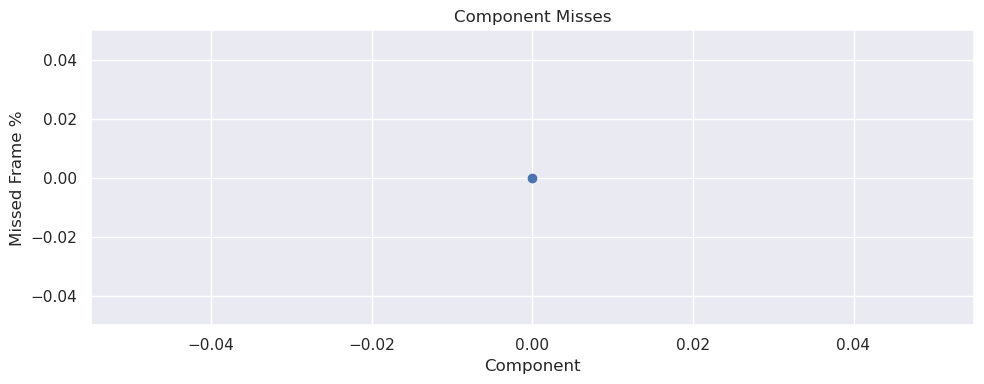

In [197]:
y = []
x = []
for index, cmpnt_id in enumerate(cmpnt_ids):
    # Filter lines for this component
    missed_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "Missed frame ratio" in line]
    # Get the last match, if any
    if missed_lines:
        last_match = missed_lines[-1]
        #print("Last matching line:")
        #print(last_match)
    else:
        print(f"No matches found for '{search_string}'")

    match = re.search(r"Missed frame ratio: ([\d.]+)", last_match)
    if match:
        value = float(match.group(1))
        #print(value)
        y.append(value*100)
        x.append(index)
    else:
        print("No match in Missed line:", last_match)
        y.append(0)
        x.append(cmpnt_id)
    
# Create a DataFrame
    misses0 = pd.DataFrame({
        'component': x,
        'fraction': y
    })

misses = misses0.sort_values(by='component', ascending=False)
    
# Plot
plt.figure(figsize=(10, 4))
plt.plot(misses['component'], misses['fraction'], marker='o', linestyle='-')
plt.title(f"Component Misses")
plt.xlabel('Component')
plt.ylabel('Missed Frame %')
plt.ylim(0, max(misses['fraction']) * 1.2)
plt.grid(True)
plt.tight_layout()
plt.show()

# Define the search term and file path
#search_string = "drop"
#file_path = "log.txt"  # replace with your file path

# Read and filter lines
#with open(file_path, 'r') as f:
#    matches = [line.strip() for line in f if search_string in line]

# Get the last match, if any
#if matches:
#    last_match = matches[-1]
#    print("Last matching line:")
#    print(last_match)
#else:
#    print(f"No matches found for '{search_string}'")


In [198]:
#missed_lines

In [199]:
#drops['fraction'].sum()

In [200]:
# misses

In [201]:
#misses['fraction']-drops['fraction']

In [202]:
def find_missing_integers(sequence):
    if not sequence:
        return [], 0

    sorted_seq = sorted(set(sequence))
    full_range = set(range(sorted_seq[0], sorted_seq[-1] + 1))
    missing = sorted(full_range - set(sorted_seq))

    return missing, len(missing)

# Example usage:
sequence = [1, 2, 4, 7, 8]
missing_values, count = find_missing_integers(sequence)

print("Missing integers:", missing_values)
print("Count:", count)


Missing integers: [3, 5, 6]
Count: 3


In [203]:
def find_missing_integers(sequence):
    if not sequence:
        return [], 0

    sorted_seq = sorted(set(sequence))
    full_range = set(range(sorted_seq[0], sorted_seq[-1] + 1))
    missing = sorted(full_range - set(sorted_seq))

    return missing, len(missing)

for index, cmpnt_id in enumerate(cmpnt_ids):
#for cmpnt_id in cmpnt_ids:
    print(f"\n🔧 Component {index}:")
    # Filter lines for this component
    comp_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "dropped" in line]
    # Parse bit rate values and timestamps
    x  = []
    for line in comp_lines:
        match = re.search(r"dropped \(([\d.]+)\)", line)
        if match:
            value = int(match.group(1))
            #print(value)
            x.append(value)
        else:
            print("No match in Missed line:", last_match)
    print(f"Number droppeed = {len(x)}")

    # x.append(1000)
    # missing_values, count = find_missing_integers(x)
    
    # print("Missing integers:", missing_values)
    # print("Count:", count)
    
    


🔧 Component 0:
Number droppeed = 0


In [204]:
# x[0:5]


🔧 Component 6000:


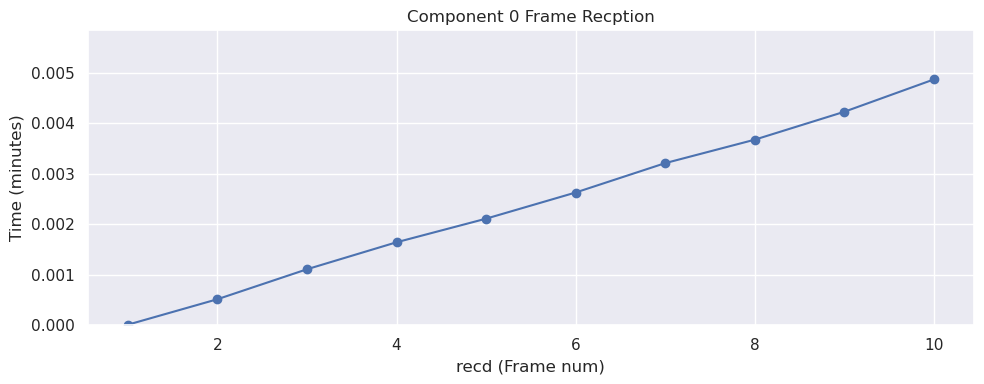

In [205]:
for index, cmpnt_id in enumerate(cmpnt_ids):
    y = []
    x = []
    print(f"\n🔧 Component {cmpnt_id}:")
    # Filter lines for this component
    recd_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "recd" in line]
    # Parse bit rate values and timestamps
    for line in recd_lines:
        match = re.search(r"recd ([\d.]+)", line)
        if match:
            value = float(match.group(1))
            y.append(value)
            ts_match = re.match(r"([\d.]+)", line)
            x.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in recd line:", line)
    
    # Create a DataFrame
    #print("len(lines)=",len(lines))
    #print("len(comp_lines)=",len(comp_lines))
    #print("len(x)=",len(x))
    recd = pd.DataFrame({
        'timestamp': x,
        'frame': y
    })

    # Convert microseconds to zero based minutes
    recd['minutes'] = ((recd['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    # Compute statistics
    recd_stats = compute_moments(recd['frame'])
    
    # Display statistics
    #print(f"Component {component_id} Statistics (Hz):")
    
    #for k, v in recd_stats.items():
        #print(f"{k}: {v:.3f}")
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(recd['frame'].head(10), recd['minutes'].head(10), marker='o', linestyle='-')
    plt.title(f"Component {index} Frame Recption")
    plt.ylabel('Time (minutes)')
    plt.xlabel('recd (Frame num)')
    plt.ylim(0, max(recd['minutes'].head(10)) * 1.2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [206]:
# recd_lines[:5]

/scratch/slurm/51154007/.cache/tmp/ipykernel_659231/802805292.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


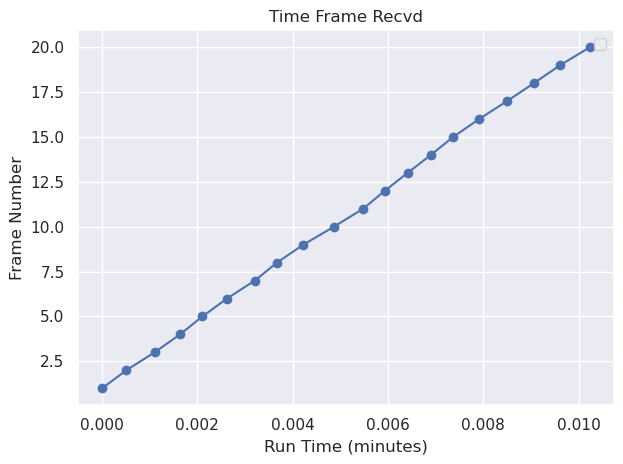

In [207]:
for cmpnt_id in cmpnt_ids:
    y = []
    x = []
    # Filter lines for this component
    recd_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "recd" in line]
    # Parse bit rate values and timestamps
    for line in recd_lines:
        match = re.search(r"recd ([\d.]+)", line)
        if match:
            value = float(match.group(1))
            y.append(value)
            ts_match = re.match(r"([\d.]+)", line)
            x.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in recd line:", line)
    
    # Create a DataFrame
    recd = pd.DataFrame({
        'timestamp': x,
        'frame': y
    })

    # Convert microseconds to zero based minutes
    recd['minutes'] = ((recd['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    # Compute statistics
    #recd_stats = compute_moments(recd['frame'])
    
    # Display statistics
    #print(f"Component {component_id} Statistics (Hz):")
    
    #for k, v in recd_stats.items():
        #print(f"{k}: {v:.3f}")
    
    # Plot
    plt.plot(recd['minutes'].head(20), recd['frame'].head(20), marker='o', linestyle='-')
    
# Add labels and legend
plt.xlabel('Run Time (minutes)')
plt.ylabel('Frame Number')
plt.title('Time Frame Recvd')
plt.legend()

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


/scratch/slurm/51154007/.cache/tmp/ipykernel_659231/919471509.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


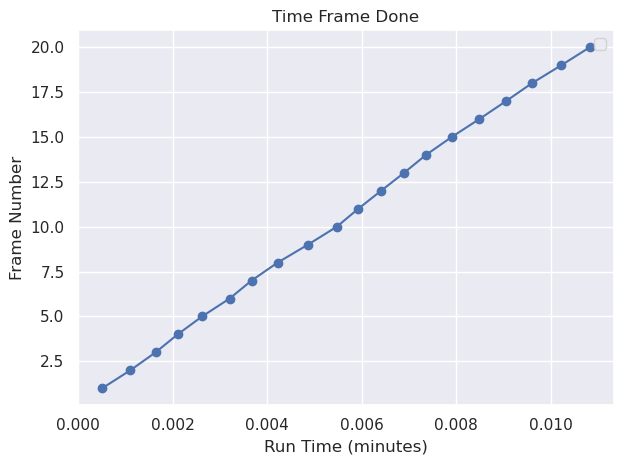

In [208]:
for cmpnt_id in cmpnt_ids:
    y = []
    x = []
    # Filter lines for this component
    done_lines = [line for line in lines if f"cpu_emu {cmpnt_id}" in line and "done" in line]
    # Parse bit rate values and timestamps
    for line in done_lines:
        match = re.search(r"done (\([\d.]+\))", line)
        if match:
            #print(match.group(1))
            #print(match.group(1).strip("()"))
            value = float(match.group(1).strip("()"))
            #print(value)
            y.append(value)
            ts_match = re.match(r"([\d.]+)", line)
            x.append(ts_match.group(1) if ts_match else None)
        else:
            print("No match in done line:", line)
    
    # Create a DataFrame
    done = pd.DataFrame({
        'timestamp': x,
        'frame': y
    })

    # Convert microseconds to zero based minutes
    done['minutes'] = ((done['timestamp'].astype(float)-min_uS) * u_1)/60  #minutes
    
    # Compute statistics
    #recd_stats = compute_moments(recd['frame'])
    
    # Display statistics
    #print(f"Component {component_id} Statistics (Hz):")
    
    #for k, v in recd_stats.items():
        #print(f"{k}: {v:.3f}")
    
    # Plot
    plt.plot(done['minutes'].head(20), done['frame'].head(20), marker='o', linestyle='-')
    
# Add labels and legend
plt.xlabel('Run Time (minutes)')
plt.ylabel('Frame Number')
plt.title('Time Frame Done')
plt.legend()

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [209]:
# done_lines[0:5]

In [210]:
#import matplotlib.pyplot as plt

# Example data
#x = [0, 1, 2, 3, 4]
#y1 = [0, 1, 4, 9, 16]
#y2 = [0, 1, 2, 3, 4]
#y3 = [16, 9, 4, 1, 0]

# Plot each series with a label
#plt.plot(x, y1, label='y = x^2', color='blue')
#plt.plot(x, y2, label='y = x', color='green')
#plt.plot(x, y3, label='y = -x^2', color='red')

# Add labels and legend
#plt.xlabel('X-axis')
#plt.ylabel('Y-axis')
#plt.title('Multiple Series on One Plot')
#plt.legend()

# Show grid and plot
#plt.grid(True)
#plt.tight_layout()
#plt.show()


In [211]:
#done.head(20)

In [212]:
# for index, item in enumerate(cmpnt_ids):
#     print(f"{index}: {item}")
